In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import easydict
from tqdm.notebook import trange, tqdm
import seaborn as sns

In [2]:
torch.manual_seed(0)

In [3]:
"""
Data
"""
# 앞의 3개 피쳐만 쓸거면: 3,12 
# 앞의 6개 피쳐만 쓸거면: 6,12 (전류포함)
# 뒤의 6개 피쳐만 쓸거면: 0,6 (vibration만)
# 전체 데이터를 쓸거면: 6,12
feature_num = 6
feature_num2 = 12
strength = 0.2
"""
Mode
"""
# Train or Test
Mode = 'Test'

"""
Model
"""
AVE = '/content/drive/MyDrive/Colab Notebooks/모델들/VAE(6feature).pt'
Discriminator_model = '/content/drive/MyDrive/Colab Notebooks/모델들/discriminator(6feature).pt'
Generator_model = '/content/drive/MyDrive/Colab Notebooks/모델들/generator(6feature).pt'

In [4]:
args = easydict.EasyDict({
    "batch_size": 128, ## 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU 사용 여부 설정
    "input_size": 6, ## 입력 차원 설정
    "latent_size2":3, ## Hidden 차원 설정
    "latent_size": 3, ## Hidden 차원 설정
    "output_size": 6, ## 출력 차원 설정
    "window_size" : 100, ## sequence Lenght
    "num_layers": 2,     ## LSTM layer 갯수 설정
    "learning_rate" : 0.01, ## learning rate 설정
    "max_iter" : 20000, ## 총 반복 횟수 설정
    'early_stop' : True,  ## valid loss가 작아지지 않으면 early stop 조건 설정
    "num" : 0, ##window size에서 몇번째 index의 데이터를 활용할지
})

# Data prepare

In [5]:
def minmax_scaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [6]:
def Call_data(input_file, feature_num, feature_num2):
  #데이터 파일을 불러옴
  xy=pd.read_table(input_file,sep=',')

  #timestamp를 시간 형식으로 전환
  xy['date'] = pd.to_datetime(xy['timestamp'])
  del xy['timestamp']
  xy = xy.set_index('date')

  #데이터의 feature들의 scale을 맞춰줌.
  train_xy=minmax_scaler(xy)


  #데이터의 앞의 3열만을 불러옴
  for col in train_xy.columns[range(feature_num,feature_num2)]:
      del train_xy[col]

  #데이터 그래프로 확인
  for col in train_xy.columns[:3]:
      plt.plot(train_xy[col],label=col)
  plt.legend()
  plt.show()

  #데이터 확인
  print(train_xy.head())

  return train_xy

In [7]:
def Split_data(data):
  interval_n = int(len(data)/10)
  train_data = data.iloc[0:interval_n*6] # 학습 데이터
  validate_data = data.iloc[interval_n*6:interval_n*8] # 검증 데이터
  test_data = data.iloc[int(interval_n*8):] # 테스트 데이터

  return train_data, validate_data, test_data

In [8]:
def Generate_noise(data, ratio, strength):
  interval_n = int(len(data)/10)
  normal_data = data.iloc[0:interval_n*ratio[0]]
  anomal_data = data.iloc[interval_n*ratio[0]:interval_n*ratio[1]]
  normal_data2 = data.iloc[interval_n*ratio[1]:]

  Normal_data = np.array(normal_data)
  Anomal_data = np.array(anomal_data)
  Normal_data2 = np.array(normal_data2)

  noise_matrix = np.random.normal(0,strength,(Anomal_data.shape[1],Anomal_data.shape[1]))
  noise_data = np.dot(Anomal_data,noise_matrix)

  margin_data = np.append(Normal_data,noise_data,axis=0)
  margin_data = np.append(margin_data,Normal_data2,axis=0)

  anomal_idx = range(len(Normal_data),len(Normal_data)+len(Anomal_data))

  x = np.arange(0,len(margin_data),1)

  for i in range(margin_data.shape[1]):
    plt.plot(x,margin_data[:,i],'b')
    plt.show()

  return margin_data, anomal_idx

In [9]:
def make_data_idx(data, window_size):
  input_idx = []
  for idx in range(window_size-1, len(data)):
    input_idx.append(list(range(idx - window_size+1, idx+1)))

  return input_idx

In [10]:
# import some packages you need here

class Get_Dataset(Dataset):

    def __init__(self, data, Windowsize):
      
      self.input_ids = make_data_idx(data, Windowsize)

      self.var_data = np.array(data)
      self.var_data = torch.FloatTensor(self.var_data)

    def __len__(self):

        # write your codes here
        return len(self.input_ids)

    def __getitem__(self, idx):
      temp_input_ids = self.input_ids[idx]
      input_values = self.var_data[temp_input_ids]

      return input_values

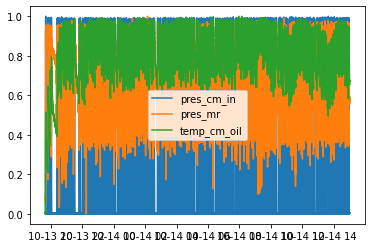

                         pres_cm_in   pres_mr  ...  curr_v  curr_w
date                                           ...                
2020-10-13 19:39:45.010    0.001054  0.072222  ...     0.0     0.0
2020-10-13 19:39:45.130    0.003161  0.066667  ...     0.0     0.0
2020-10-13 19:39:46.340    0.001054  0.066667  ...     0.0     0.0
2020-10-13 19:39:46.440    0.002107  0.072222  ...     0.0     0.0
2020-10-13 19:39:46.550    0.001054  0.061111  ...     0.0     0.0

[5 rows x 6 columns]


In [11]:
# 앞의 3개 피쳐만 쓸거면: 3,12 
# 앞의 6개 피쳐만 쓸거면: 6,12 (전류포함)
# 뒤의 6개 피쳐만 쓸거면: 0,6 (vibration만)
# 전체 데이터를 쓸거면: 0,0
#텍스트 파일로 저장된 데이터를 불러옴 이때 활용할 feature의 개수를 입력해줌.
train_xy = Call_data('/content/drive/MyDrive/Colab Notebooks/5.txt',feature_num,feature_num2)

In [12]:
#데이터를 train, validate, test 데이터 3가지로 나눔.
train_data, validate_data, test_data = Split_data(train_xy)

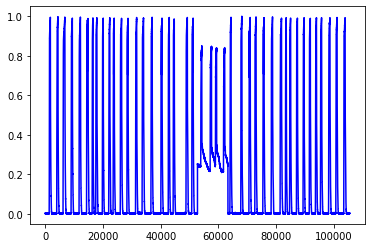

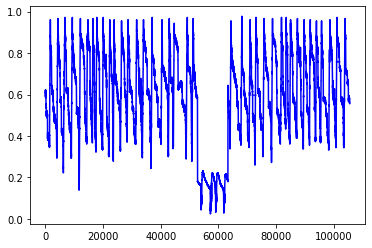

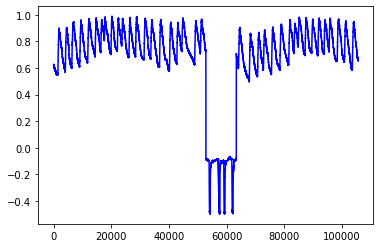

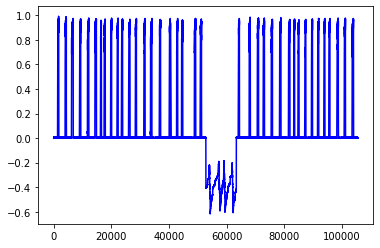

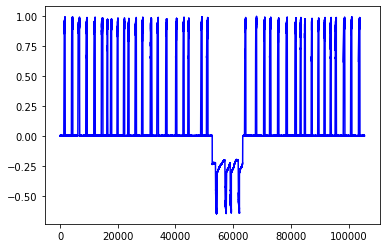

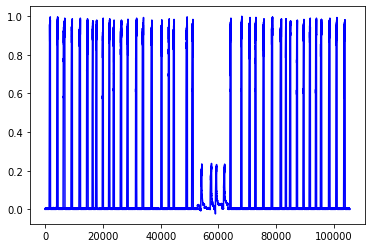

In [13]:
#Test 데이터에 고의적으로 노이즈를 입힘, 노이즈의 비율과 강도를 조절할 수 있음.
test_data2, anomal_idx = Generate_noise(test_data, [5,6], strength)

In [14]:
#데이터 셋을 구성함.
train_dataset = Get_Dataset(train_data, args.window_size)
validate_dataset = Get_Dataset(validate_data, args.window_size)
test_dataset = Get_Dataset(test_data2, args.window_size)

In [15]:
#로더 형태로 변환함
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=args.batch_size,
                 shuffle=True)
valid_loader = torch.utils.data.DataLoader(
                dataset=validate_dataset,
                batch_size=args.batch_size,
                shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=args.batch_size,
                shuffle=False)

# MAD-GAN

In [16]:
## 인코더
class Encoder(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers):
      super(Encoder, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                          dropout=0.1, bidirectional=False)
                 
      self.hidden2mean = nn.Linear(self.hidden_size*self.num_layers, self.hidden_size)
      self.hidden2logv = nn.Linear(self.hidden_size*self.num_layers, self.hidden_size)
      
  def encode(self,x):

    mu = self.hidden2mean(x)
    log_var = self.hidden2logv(x)

    return mu, log_var

  def reparametrize(self, mu, logvar):

    std = logvar.mul(0.5).exp_()

    z = torch.randn([self.num_layers, self.batch_size, self.hidden_size]).to(args.device)
    z = z * std + mu
    return z

  def forward(self, x):
    self.batch_size, _, _ = x.size()

    _, (hidden,cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

    if self.num_layers > 1:
      # flatten hidden state
      hidden = hidden.view(self.batch_size, self.hidden_size*self.num_layers)
    else:
      hidden = hidden.squeeze()

    mu, logvar = self.encode(hidden)
    z = self.reparametrize(mu,logvar)

    return mu, logvar, (z,cell)

## Discriminator
class Discriminator(nn.Module):

  def __init__(self, batch_size,input_size, hidden_size, num_layers):
    super().__init__()
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)
    self.fc = nn.Sequential(
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

  def forward(self, x):
    outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

    output = self.fc(outputs)

    num_dims = len(output.shape)
    reduction_dims = tuple(range(1, num_dims))
    # (batch_size)
    output = torch.mean(output, dim=reduction_dims)

    return output

## Generator
class Generator(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(Generator, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, latent):

    output, (_,_) = self.lstm(x, latent)  # out: tensor of shape (batch_size, seq_length, hidden_size)
    prediction = self.fc(output)

    return prediction

def loss_function_VAE(reconstruct_output, batch_data, mu, log_var):

  recon_x = reconstruct_output
  x = batch_data
  mu = mu
  logvar = log_var

  MSE = F.mse_loss(recon_x, x)

  KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
  KLD = torch.sum(KLD_element).mul_(-0.5)

  return MSE + KLD

def loss_function_discriminator(window_size, output_discriminator_real, output_discriminator_generated, real_samples_labels, generated_samples_labels):
  loss_discriminator_real = 0
  loss_discriminator_generated = 0

  output_discriminator_generated = torch.stack(output_discriminator_generated, dim=1)
  output_discriminator_real = torch.stack(output_discriminator_real, dim=1)

  output_discriminator_real = torch.clamp(output_discriminator_real, 1e-40, 1.0)
  loss_discriminator_real = -torch.log(output_discriminator_real)

  output_discriminator_generated = torch.clamp(output_discriminator_generated, 1e-40, 1.0)  
  loss_discriminator_generated = -torch.log(1-output_discriminator_generated)

  batch_loss = loss_discriminator_real + loss_discriminator_generated

  return torch.mean(batch_loss)

def loss_function_Generator(window_size, output_discriminator_generated, real_samples_labels):
  loss_Generator = 0

  output_discriminator_generated = torch.stack(output_discriminator_generated, dim=1)

  output_discriminator_generated = torch.clamp(output_discriminator_generated, 1e-40, 1.0)
  loss_Generator = -torch.log(output_discriminator_generated)

  return torch.mean(loss_Generator)

In [17]:
def Model_initialize(input_dim, latent_dim2 ,latent_dim, window_size, num_layers, batch_size):

  discriminator = Discriminator(
              batch_size=args.batch_size,
              input_size=input_dim,
              hidden_size=latent_dim,
              num_layers=num_layers,
          )

  generator = Generator(
              input_size=input_dim,
              output_size=input_dim,
              hidden_size=latent_dim2,
              num_layers=num_layers,
          )
  encoder = Encoder(
              input_size=input_dim,
              hidden_size=latent_dim2,
              num_layers=num_layers,
          )
  return encoder, discriminator, generator

def run(args, model_VAE, model_discriminator, model_generator, train_loader, test_loader):

  # optimizer 설정
  optimizer_VAE = torch.optim.Adam(model_VAE.parameters(), lr=args.learning_rate)
  optimizer_discriminator = torch.optim.Adam(model_discriminator.parameters(), lr=args.learning_rate)
  optimizer_generator = torch.optim.Adam(model_generator.parameters(), lr=args.learning_rate)

  ## 반복 횟수 Setting
  epochs = tqdm(range(args.max_iter//len(train_loader)+1))
  
  ## 학습하기
  count = 0
  best_loss_VAE = 100000000
  best_loss_GAN = 100000000

  for epoch in epochs:

    model_VAE.train()
    model_discriminator.train()
    model_generator.train()

    optimizer_VAE.zero_grad()
    optimizer_discriminator.zero_grad()
    optimizer_generator.zero_grad()
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

    for i, batch_data in train_iterator:
      batch_data = batch_data.to(args.device)
      batch_size, sequence_length, var_length = batch_data.size()

      real_samples_labels = torch.ones((batch_size, 1))
      generated_samples_labels = torch.zeros((batch_size, 1))

      mu, log_var, encoder_latent = model_VAE(batch_data)

      inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
      output_discriminator_real = []
      output_discriminator_generated = []
      reconstruct_output = []

      temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(batch_data.device)
      hidden = encoder_latent

      for t in range(sequence_length):
          temp_input = model_generator(temp_input, hidden)
          temp_output_discriminator_generated = model_discriminator(temp_input)
          temp_output_discriminator_real = model_discriminator(batch_data[:,t,:].unsqueeze(1))

          output_discriminator_real.append(temp_output_discriminator_real)
          output_discriminator_generated.append(temp_output_discriminator_generated)
          reconstruct_output.append(temp_input)

      reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]

      if count > args.max_iter:
          return model_VAE, model_discriminator, model_generator
      count += 1
      
      batch_data = batch_data.to(args.device)

      loss_VAE = loss_function_VAE(reconstruct_output, batch_data, mu, log_var)
      loss_discriminator = loss_function_discriminator(args.window_size, output_discriminator_real, output_discriminator_generated, real_samples_labels, generated_samples_labels)
      loss_Generator = loss_function_Generator(args.window_size, output_discriminator_generated, real_samples_labels)

      # Backward and optimize
      loss_VAE.backward(retain_graph=True)
      loss_discriminator.backward(retain_graph=True)
      loss_Generator.backward(retain_graph=True)

      optimizer_VAE.step()
      optimizer_discriminator.step()
      optimizer_generator.step()

      optimizer_VAE.zero_grad()
      optimizer_discriminator.zero_grad()
      optimizer_generator.zero_grad()
      
      train_iterator.set_postfix({
          "loss_VAE": float(loss_VAE),"loss_discriminator": float(loss_discriminator),"loss_Generator": float(loss_Generator)
      })

    model_VAE.eval()
    model_discriminator.eval()
    model_generator.eval()

    eval_loss_VAE = 0
    eval_loss_discriminator = 0
    eval_loss_Generator = 0

    eval_loss = 0

    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    with torch.no_grad():
        for i, batch_data in test_iterator:
          batch_data = batch_data.to(args.device)
          batch_size, sequence_length, var_length = batch_data.size()

          real_samples_labels = torch.ones((batch_size, 1))
          generated_samples_labels = torch.zeros((batch_size, 1))

          mu, log_var, encoder_latent = model_VAE(batch_data)

          inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
          output_discriminator_real = []
          output_discriminator_generated = []
          reconstruct_output = []

          temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(batch_data.device)
          hidden = encoder_latent

          for t in range(sequence_length):
            temp_input = model_generator(temp_input, hidden)
            temp_output_discriminator_generated = model_discriminator(temp_input)
            temp_output_discriminator_real = model_discriminator(batch_data[:,t,:].unsqueeze(1))

            output_discriminator_real.append(temp_output_discriminator_real)
            output_discriminator_generated.append(temp_output_discriminator_generated)
            reconstruct_output.append(temp_input)

          reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
          
          batch_data = batch_data.to(args.device)

          loss_VAE = loss_function_VAE(reconstruct_output, batch_data, mu, log_var)
          loss_discriminator = loss_function_discriminator(args.window_size , output_discriminator_real, output_discriminator_generated, real_samples_labels, generated_samples_labels)
          loss_Generator = loss_function_Generator(args.window_size, output_discriminator_generated, real_samples_labels)

          eval_loss_VAE += loss_VAE.mean().item()
          eval_loss_discriminator += loss_discriminator.mean().item()
          eval_loss_Generator += loss_Generator.mean().item()

          test_iterator.set_postfix({
              "eval_loss_VAE": float(loss_VAE),"eval_loss_discriminator": float(loss_discriminator),"eval_loss_Generator": float(loss_Generator),
          })
    eval_loss_VAE = eval_loss_VAE / len(test_loader)
    eval_loss_discriminator = eval_loss_discriminator / len(test_loader)
    eval_loss_Generator = eval_loss_Generator / len(test_loader)
    epochs.set_postfix({
          "Evaluation Score_VAE": float(loss_VAE), "Evaluation Score_discriminator": float(loss_discriminator), "Evaluation Score_Generator": float(loss_Generator),
    })

    if (eval_loss_VAE < best_loss_VAE and eval_loss_discriminator+eval_loss_Generator < best_loss_GAN):

      best_loss_VAE = eval_loss_VAE
      best_loss_GAN = eval_loss_discriminator + eval_loss_Generator

    else:
      if args.early_stop:
          print('early stop condition   best_loss_VAE[{}]  best_loss_GAN[{}]  eval_loss_VAE[{}]  eval_loss_discriminator[{}]  eval_loss_Generator[{}]'
          .format(best_loss_VAE, best_loss_GAN, eval_loss_VAE,eval_loss_discriminator,eval_loss_Generator))
          return model_VAE, model_discriminator, model_generator

    torch.save(model_VAE,'/content/drive/MyDrive/Colab Notebooks/VAE(6feature_vib).pt')
    torch.save(model_discriminator,'/content/drive/MyDrive/Colab Notebooks/discriminator(6feature_vib).pt')
    torch.save(model_generator,'/content/drive/MyDrive/Colab Notebooks/generator(6feature_vib).pt')
  return model_VAE, model_discriminator, model_generator

In [18]:
def discriminate(args, model_discriminator, test_loader):
  test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
  output_discriminate = []
  with torch.no_grad():
    for i, batch_data in test_iterator:
      batch_data = batch_data.to(args.device)
      batch_size, sequence_length, var_length = batch_data.size()
      temp_output_discriminate = model_discriminator(batch_data)
      temp_output_discriminate = temp_output_discriminate >= torch.FloatTensor([0.5]).to(args.device)
      for i in range(len(temp_output_discriminate)):
        output_discriminate.append(temp_output_discriminate[i])

  return output_discriminate

In [108]:
def reconstruction(args, model_VAE, model_generator, test_loader, num):
  test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
  loss_list = []
  predictions = []
  true_data = []
  with torch.no_grad():
    for i, batch_data in test_iterator:
      batch_data = batch_data.to(args.device)    
      batch_size, sequence_length, var_length = batch_data.size()
      mu, log_var, encoder_latent = model_VAE(batch_data)
      inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
      reconstruct_output = []

      temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(batch_data.device)
      hidden = encoder_latent
      for t in range(sequence_length):
        temp_input = model_generator(temp_input, hidden)
        reconstruct_output.append(temp_input)

      reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
      batch_data = batch_data.to(args.device)

      for k in range(len(reconstruct_output)):
        predictions.append(reconstruct_output[k][num])
        true_data.append(batch_data[k][num])

      
  for i in range(len(predictions)-50):
    Temp_loss_list=abs(predictions[i]-true_data[i+50]).mean()
    loss_list.append(Temp_loss_list)

  return loss_list,predictions,true_data

In [107]:
def Get_Threshold(args, model_VAE, model_generator, model_discriminator, test_loader, num, gamma):
  output_discriminate = discriminate(args, model_discriminator, test_loader)
  loss_list,predictions,true_data = reconstruction(args, model_VAE, model_generator, test_loader, num)
  Res= []
  for i in range(len(loss_list)):
    Res.append(loss_list[i].mean())

  Score = []
  for i in range(len(output_discriminate)-50):
    if output_discriminate[i] == False:
      Score.append(gamma*(Res[i])+(1-gamma))
    else:
      Score.append(gamma*(Res[i]))

  sns.distplot(Score, bins=50, kde=True);

  return Score,predictions,true_data

In [21]:
def get_Accuracy(Score, anomal_idx, THRESHOLD, num):
  anomaly_index_true = range(anomal_idx[0]-(num+1),anomal_idx[-1]-(num+1))
  anomaly_index_predict = []
  correct_anomaly = []
  uncorrect_normal = []
  for i in range(0,len(Score)):
    if Score[i] >= THRESHOLD:
      anomaly_index_predict.append(i)

  for i in range(0,len(anomaly_index_predict)):
    k = anomaly_index_predict[i]
    if k in anomaly_index_true:
      correct_anomaly.append(k)
    if k not in anomaly_index_true:
      uncorrect_normal.append(k)


  print(f'Correct anomaly predictions: {len(correct_anomaly)}/{len(anomaly_index_true)}')
  print("Accuracy: {:.2f}%".format(len(correct_anomaly)/len(anomaly_index_true)*100))
  print(f'Miss anomaly predictions: {len(uncorrect_normal)}/{len(Score)-len(anomaly_index_true)}')
  print("Error: {:.2f}%".format(len(uncorrect_normal)/len(Score)*100))

  return correct_anomaly, uncorrect_normal

In [22]:
def compare_plot(predictions, true_data, correct_anomaly, uncorrect_normal, num):
  predict=[]
  true=[]
  correct_anomaly_predict=[]
  uncorrect_normal_predict=[]


  for i in range(len(predictions)):
    predict.append(predictions[i][num])
    true.append(true_data[i][num])
  
  for i in correct_anomaly:
    correct_anomaly_predict.append(predict[i])
  for i in uncorrect_normal:
    uncorrect_normal_predict.append(true[i])

  predict = np.array(predict)
  true = np.array(true)
  correct_anomaly_predict = np.array(correct_anomaly_predict)
  uncorrect_normal_predict = np.array(uncorrect_normal_predict)

  total_x = len(predict)
  x = np.arange(0,total_x,1)

  plt.figure(figsize=(16, 6))
  plt.plot(x,predict,'b',label='predict')
  plt.plot(x,true,'r',label='true')
  plt.plot(correct_anomaly,correct_anomaly_predict,'*g',label='correct_anomaly')
  plt.plot(uncorrect_normal,uncorrect_normal_predict,'ok',label='miss')
  plt.legend(loc='upper right')
  plt.show()

In [23]:
model_VAE, model_discriminator, model_generator = Model_initialize(input_dim=args.input_size, latent_dim2=args.latent_size2, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers, batch_size=args.batch_size)
model_VAE.to(args.device)
model_discriminator.to(args.device)
model_generator.to(args.device)

Generator(
  (lstm): LSTM(6, 3, num_layers=2, batch_first=True, dropout=0.1)
  (relu): ReLU()
  (fc): Linear(in_features=3, out_features=6, bias=True)
)

# Result

In [26]:
## 학습하기
if Mode == 'Train':
  model_VAE, model_discriminator, model_generator = run(args, model_VAE, model_discriminator, model_generator, train_loader, valid_loader)


In [27]:
if Mode == 'Test':
  model_VAE = torch.load(AVE)
  model_discriminator = torch.load(Discriminator_model)
  model_generator = torch.load(Generator_model)
  model_VAE.to(args.device)
  model_discriminator.to(args.device)
  model_generator.to(args.device)

In [28]:
model_VAE.eval()
model_discriminator.eval()
model_generator.eval()

Generator(
  (lstm): LSTM(6, 3, num_layers=2, batch_first=True, dropout=0.1)
  (relu): ReLU()
  (fc): Linear(in_features=3, out_features=6, bias=True)
)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


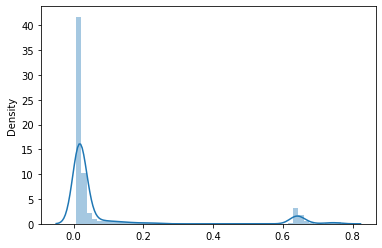

In [105]:
Score,predictions,true_data = Get_Threshold(args, model_VAE, model_generator, model_discriminator, test_loader, 0, 0.5)

In [106]:
THRESHOLD = 0.2
correct_anomaly, uncorrect_normal = get_Accuracy(Score, anomal_idx,THRESHOLD,0)

Correct anomaly predictions: 10472/10549
Accuracy: 99.27%
Miss anomaly predictions: 950/94852
Error: 0.90%


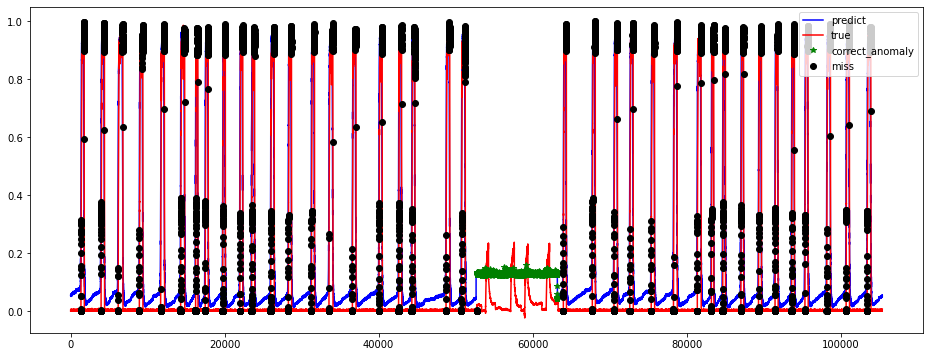

In [101]:
#Test 데이터를 직접 플롯하고, 이상 데이터를 잘 감지했는지 시각화함.
compare_plot(predictions, true_data, correct_anomaly, uncorrect_normal,5)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
output_discriminate = discriminate(args, model_discriminator, test_loader)

In [34]:
c=0
for i in range(len(output_discriminate)):
  if output_discriminate[i]==True:
    c = c+1

print(c)
print(len(output_discriminate))

94922
105404
